# Introduksjon til GeoPandas

GeoPandas utvider pandas med romlige funksjoner, slik at du kan jobbe med geometriske data og utfore romlige operasjoner.

## Laeringsmaal
- Laste og utforske romlige data (GeoParquet)
- Utfore grunnleggende romlige operasjoner (buffer, sentroid, areal)
- Visualisere geografiske data
- Utfore romlige joiner
- Gjore mer avansert romlig analyse

## Data
Vi bruker tre eksempeldata:
- `buildings_sample.parquet` - Bygningsavtrykk
- `flomsoner_sample.parquet` - Flomsoner
- `sykkelrute_senterlinje_sample.parquet` - Sykkelruter (senterlinjer)

In [ ]:
import subprocess

subprocess.run([
    "uv", "pip", "install",
    "geopandas",
    "matplotlib",
    "pyarrow",
    "folium",
    "mapclassify",
    "scikit-learn"
])

Using Python 3.12.12 environment at: /Users/alexandesn/dev/.virtualenvs/geoenv
Resolved 33 packages in 606ms
 Downloaded networkx
 Downloaded scikit-learn
 Downloaded scipy
Prepared 9 packages in 2.63s
Installed 9 packages in 26ms
 + branca==0.8.2
 + folium==0.20.0
 + joblib==1.5.3
 + mapclassify==2.10.0
 + networkx==3.6.1
 + scikit-learn==1.8.0
 + scipy==1.17.1
 + threadpoolctl==3.6.0
 + xyzservices==2025.11.0


CompletedProcess(args=['uv', 'pip', 'install', 'geopandas', 'matplotlib', 'pyarrow', 'folium', 'mapclassify'], returncode=0)

In [2]:
from pathlib import Path
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Juster stien til der parquet-filene ligger
data_dir = Path("outputs/geoparquet")

# Last inn eksempeldataene
buildings = gpd.read_parquet(data_dir / "buildings_sample.parquet")
flood_zones = gpd.read_parquet(data_dir / "flomsoner_sample.parquet")
cycle_routes = gpd.read_parquet(data_dir / "sykkelrute_senterlinje_sample.parquet")

print("Data lastet inn!")
print(f"Bygninger: {len(buildings)} rader")
print(f"Flomsoner: {len(flood_zones)} rader")
print(f"Sykkelruter: {len(cycle_routes)} rader")

Data lastet inn!
Bygninger: 10000 rader
Flomsoner: 10000 rader
Sykkelruter: 10000 rader


## Oppvarming: Grunnleggende utforsking

In [3]:
# Undersok bygningsdatasettet
print("Bygningsdatasett:")
print(buildings.head())
print("\nDatatyper:")
print(buildings.dtypes)
print("\nGeometriinfo:")
print(f"CRS: {buildings.crs}")
print(f"Total utstrekning: {buildings.total_bounds}")

Bygningsdatasett:
       gid     osm_id  code    fclass name            type  \
0   302517  256981899  1500  building  NaN           house   
1  1113866  917527996  1500  building  NaN           house   
2  2741098  955796078  1500  building  NaN           house   
3   484043  474890912  1500  building  NaN           cabin   
4   921733  758449296  1500  building  NaN  farm_auxiliary   

                                                geom  
0  MULTIPOLYGON (((288942.997 6744145.842, 288950...  
1  MULTIPOLYGON (((129759.699 6490193.475, 129767...  
2  MULTIPOLYGON (((227523.045 6566245.912, 227535...  
3  MULTIPOLYGON (((351428.915 7026602.968, 351431...  
4  MULTIPOLYGON (((135412.183 6623732.884, 135416...  

Datatyper:
gid          int64
osm_id         str
code         int64
fclass         str
name           str
type           str
geom      geometry
dtype: object

Geometriinfo:
CRS: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "ProjectedCRS", "name": "E

In [4]:
# Rask oversikt over alle tre datasett
datasets = {"buildings": buildings, "flood_zones": flood_zones, "cycle_routes": cycle_routes}

for name, gdf in datasets.items():
    print(f"\n{'='*50}")
    print(f"{name.upper()}")
    print(f"{'='*50}")
    print(f"Form: {gdf.shape}")
    print(f"CRS: {gdf.crs}")
    print(f"Geometritype(r): {gdf.geometry.type.unique()}")
    print(f"Kolonner: {list(gdf.columns)}")


BUILDINGS
Form: (10000, 7)
CRS: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "ProjectedCRS", "name": "ETRS89 / UTM zone 33N", "base_crs": {"name": "ETRS89", "datum_ensemble": {"name": "European Terrestrial Reference System 1989 ensemble", "members": [{"name": "European Terrestrial Reference Frame 1989"}, {"name": "European Terrestrial Reference Frame 1990"}, {"name": "European Terrestrial Reference Frame 1991"}, {"name": "European Terrestrial Reference Frame 1992"}, {"name": "European Terrestrial Reference Frame 1993"}, {"name": "European Terrestrial Reference Frame 1994"}, {"name": "European Terrestrial Reference Frame 1996"}, {"name": "European Terrestrial Reference Frame 1997"}, {"name": "European Terrestrial Reference Frame 2000"}, {"name": "European Terrestrial Reference Frame 2005"}, {"name": "European Terrestrial Reference Frame 2014"}, {"name": "European Terrestrial Reference Frame 2020"}], "ellipsoid": {"name": "GRS 1980", "semi_major_axis": 63781

In [ ]:
# Visualiser flomsonene med Lonboard. Legg merke til at Lonboard forventer WGS84 (EPSG:4326), så vi må transformere koordinatsystemet først.
from lonboard import viz

viz(flood_zones.to_crs("EPSG:4326"))

In [16]:
# Visualiser bygningene med geopandas .explore()
buildings.explore()

## Grunnleggende romlige operasjoner

In [21]:
# Beregn areal og andre geometriske egenskaper
buildings["area"] = buildings.geometry.area
buildings["perimeter"] = buildings.geometry.length

print("Bygninger med beregnede egenskaper:")
print(buildings[["area", "perimeter", "geom"]].head(10))
print(f"\nTotalt areal: {buildings['area'].sum():.2f} kvadratmeter")
print(f"Gjennomsnittlig bygningsstorrelse: {buildings['area'].mean():.2f} kvadratmeter")

Bygninger med beregnede egenskaper:
         area  perimeter                                               geom
0  189.915101  62.344049  MULTIPOLYGON (((288942.997 6744145.842, 288950...
1  137.938047  52.800897  MULTIPOLYGON (((129759.699 6490193.475, 129767...
2  157.092167  53.742298  MULTIPOLYGON (((227523.045 6566245.912, 227535...
3   84.059069  40.338676  MULTIPOLYGON (((351428.915 7026602.968, 351431...
4   26.618473  20.854010  MULTIPOLYGON (((135412.183 6623732.884, 135416...
5   13.967478  15.119177  MULTIPOLYGON (((252635.476 7008571.534, 252638...
6  164.642535  55.351554  MULTIPOLYGON (((645777.706 7689171.041, 645784...
7  104.180856  44.324819  MULTIPOLYGON (((198610.421 6766388.173, 198616...
8  135.975654  50.205649  MULTIPOLYGON (((259814.153 6652266.491, 259817...
9   43.590009  26.493105  MULTIPOLYGON (((138515.968 6494202.245, 138523...

Totalt areal: 1380043.33 kvadratmeter
Gjennomsnittlig bygningsstorrelse: 138.00 kvadratmeter


In [23]:
# Lag sentroider og buffergeometrier
buildings["centroid"] = buildings.geometry.centroid
buildings["buffer_50m"] = buildings.geometry.buffer(50)

print("Bygninger med sentroider og buffere:")
print(buildings[["centroid", "buffer_50m", "geom"]].head())

# Sjekk konveks hull og omsluttende rektangel
buildings["convex_hull"] = buildings.geometry.convex_hull
buildings["envelope"] = buildings.geometry.envelope

print(f"\nEksempel konveks hull: {buildings['convex_hull'].iloc[0]}")

Bygninger med sentroider og buffere:
                         centroid  \
0  POINT (288951.315 6744141.249)   
1  POINT (129766.994 6490196.006)   
2  POINT (227532.478 6566247.973)   
3  POINT (351435.433 7026603.416)   
4  POINT (135415.881 6623733.341)   

                                          buffer_50m  \
0  POLYGON ((288893.452 6744139.589, 288893.117 6...   
1  POLYGON ((129714.57 6490172.085, 129713.317 64...   
2  POLYGON ((227485.951 6566212.385, 227482.842 6...   
3  POLYGON ((351398.524 7026563.34, 351396.57 702...   
4  POLYGON ((135376.155 6623698.214, 135372.928 6...   

                                                geom  
0  MULTIPOLYGON (((288942.997 6744145.842, 288950...  
1  MULTIPOLYGON (((129759.699 6490193.475, 129767...  
2  MULTIPOLYGON (((227523.045 6566245.912, 227535...  
3  MULTIPOLYGON (((351428.915 7026602.968, 351431...  
4  MULTIPOLYGON (((135412.183 6623732.884, 135416...  

Eksempel konveks hull: POLYGON ((288953.03134131944 6744132.745775221, 2

In [25]:
# Geometriske sjekker
print("Geometriske egenskaper:")
print(f"Gyldige geometrier: {buildings.geometry.is_valid.sum()} / {len(buildings)}")
print(f"Tomme geometrier: {buildings.geometry.is_empty.sum()}")


Geometriske egenskaper:
Gyldige geometrier: 10000 / 10000
Tomme geometrier: 0


## Visualisering

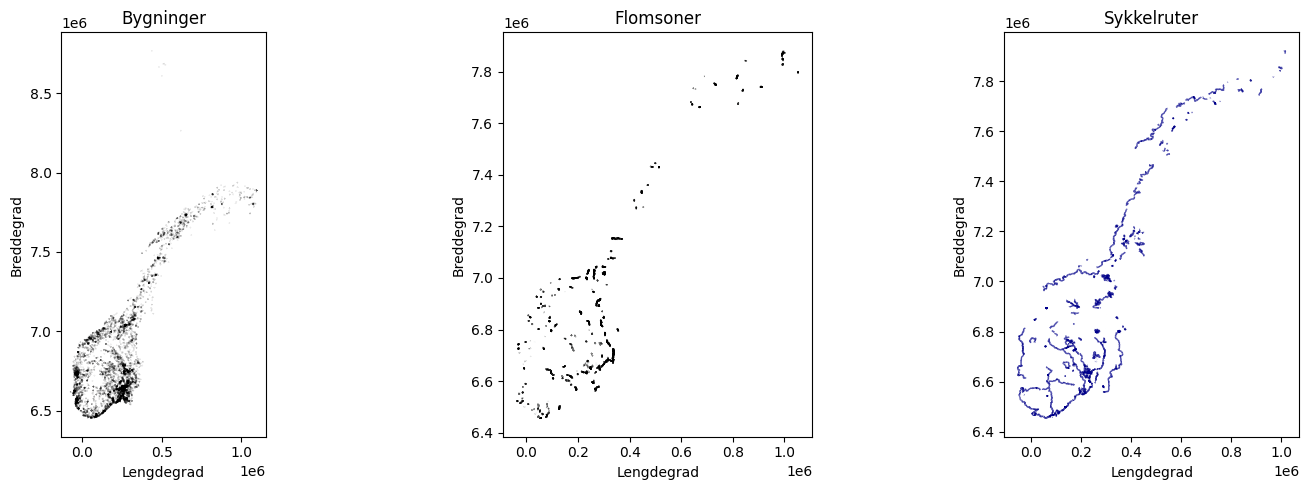

In [26]:
# Plott hvert datasett
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

buildings.plot(ax=axes[0], alpha=0.5, edgecolor='k', color='lightblue')
axes[0].set_title('Bygninger')
axes[0].set_xlabel('Lengdegrad')
axes[0].set_ylabel('Breddegrad')

flood_zones.plot(ax=axes[1], alpha=0.5, edgecolor='k', color='lightcyan')
axes[1].set_title('Flomsoner')
axes[1].set_xlabel('Lengdegrad')
axes[1].set_ylabel('Breddegrad')

cycle_routes.plot(ax=axes[2], alpha=0.7, edgecolor='darkblue', linewidth=1)
axes[2].set_title('Sykkelruter')
axes[2].set_xlabel('Lengdegrad')
axes[2].set_ylabel('Breddegrad')

plt.tight_layout()
plt.show()

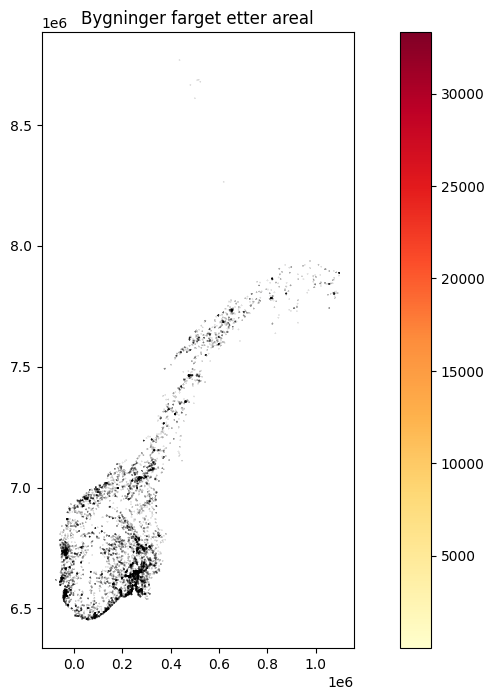

In [27]:
# Visualiser bygninger farget etter areal
fig, ax = plt.subplots(figsize=(12, 8))
buildings.plot(
    column='area',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='k',
    alpha=0.8
)
ax.set_title('Bygninger farget etter areal')
plt.show()

## Romlige operasjoner: Joiner og snitt

In [ ]:
# Romlig join: Hvilke bygninger ligger i flomsoner?
buildings_in_flood = gpd.sjoin(
    buildings,
    flood_zones,
    how="inner",
    predicate="intersects"
)

print(f"Bygninger som overlapper flomsoner: {len(buildings_in_flood)}")
print(f"\nDe forste resultatene:")
print(buildings_in_flood[['area', 'index_right', 'geom']].head())

Bygninger som overlapper flomsoner: 28

De forste resultatene:
           area  index_right  \
285  631.095056         2561   
285  631.095056         9154   
285  631.095056         9176   
349   98.344033         4560   
829  186.980339         5954   

                                                  geom  
285  MULTIPOLYGON (((88796.728 6832409.757, 88800.8...  
285  MULTIPOLYGON (((88796.728 6832409.757, 88800.8...  
285  MULTIPOLYGON (((88796.728 6832409.757, 88800.8...  
349  MULTIPOLYGON (((348106.778 7150889.101, 348112...  
829  MULTIPOLYGON (((333145.889 7154196.062, 333146...  


In [ ]:
buildings_in_flood.explore()

In [35]:
# Romlig join: Hvilke sykkelruter passerer gjennom flomsoner?
routes_in_flood = gpd.sjoin(
    cycle_routes,
    flood_zones,
    how="inner",
    predicate="intersects"
)

print(f"Sykkelrutesegmenter i flomsoner: {len(routes_in_flood)}")
print(f"\nEksempelresultater:")
print(routes_in_flood.head())

Sykkelrutesegmenter i flomsoner: 216

Eksempelresultater:
     gid_left objtype_left skilting anleggsnummer uukoblingsid belysning  \
45       5949   Sykkelrute       JA          None         None             
46       4609   Sykkelrute       JA          None         None             
81       6317   Sykkelrute       JA          None         None             
115      5813   Sykkelrute       JA          None         None             
115      5813   Sykkelrute       JA          None         None             

                             lokalid_left  \
45   9fb43352-b48e-4197-b929-23c2cbee94af   
46   40e4fff4-0cd6-4ce7-8e3d-69cd9a67ce4e   
81   f98c7a88-cf7a-443e-91a2-551f3bdaee4b   
115  7f8c5808-eabc-4723-ac13-e5fef5037045   
115  7f8c5808-eabc-4723-ac13-e5fef5037045   

                                        navnerom_left  \
45   http://data.geonorge.no/TurruterNGIS/Turruter/so   
46   http://data.geonorge.no/TurruterNGIS/Turruter/so   
81   http://data.geonorge.no/TurruterNGIS/T

## Avansert analyse

In [38]:
# Sla sammen flomsoner for total flomutstrekning
total_flood = flood_zones.dissolve()
print(f"Totalt flomareal: {total_flood.geometry.area.values[0]:.2f} kvadratmeter")

# Beregn utstrekning for flomsoner
flood_bounds = total_flood.total_bounds
print(f"\nFlomsonens avgrensning:")
print(f"  Min X: {flood_bounds[0]:.2f}")
print(f"  Min Y: {flood_bounds[1]:.2f}")
print(f"  Max X: {flood_bounds[2]:.2f}")
print(f"  Max Y: {flood_bounds[3]:.2f}")

Totalt flomareal: 260911339.05 kvadratmeter

Flomsonens avgrensning:
  Min X: -36216.95
  Min Y: 6455638.58
  Max X: 1053906.86
  Max Y: 7881100.36


In [39]:
# Finn bygninger innen 100 m fra sykkelruter
cycle_routes_buffer = cycle_routes.buffer(100)
cycle_routes_buffer_gdf = gpd.GeoDataFrame(geometry=cycle_routes_buffer, crs=cycle_routes.crs)

buildings_near_routes = gpd.sjoin(
    buildings,
    cycle_routes_buffer_gdf,
    how="inner",
    predicate="intersects"
)

print(f"Bygninger innen 100 m fra sykkelruter: {len(buildings_near_routes)} (unikke: {buildings_near_routes.index.nunique()})")
print(f"Totalt areal for disse bygningene: {buildings_near_routes['area'].sum():.2f} kvadratmeter")

Bygninger innen 100 m fra sykkelruter: 686 (unikke: 486)
Totalt areal for disse bygningene: 131261.05 kvadratmeter


In [42]:
# Beregn avstand fra hver bygning til naermeste sykkelrute
cycle_routes_union = cycle_routes.unary_union
buildings['dist_to_cycle_route'] = buildings.geometry.distance(cycle_routes_union)

print("Avstandsstatistikk til naermeste sykkelrute:")
print(buildings['dist_to_cycle_route'].describe())

# Antall bygninger innen ulike avstander
print(f"\nBygninger innen 50 m: {(buildings['dist_to_cycle_route'] <= 50).sum()}")
print(f"Bygninger innen 100 m: {(buildings['dist_to_cycle_route'] <= 100).sum()}")
print(f"Bygninger innen 200 m: {(buildings['dist_to_cycle_route'] <= 200).sum()}")

/var/folders/zc/46f48ft16d7_rtzh120yf3rr0000gp/T/ipykernel_10039/2233183229.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cycle_routes_union = cycle_routes.unary_union


Avstandsstatistikk til naermeste sykkelrute:
count    1.000000e+04
mean     1.135711e+04
std      3.094624e+04
min      1.660583e+00
25%      1.150448e+03
50%      5.652735e+03
75%      1.567025e+04
max      1.023545e+06
Name: dist_to_cycle_route, dtype: float64

Bygninger innen 50 m: 277
Bygninger innen 100 m: 486
Bygninger innen 200 m: 817


## Romlig clustering

Clustering-algoritmer brukes til å identifisere geografiske mønstre og grupper.

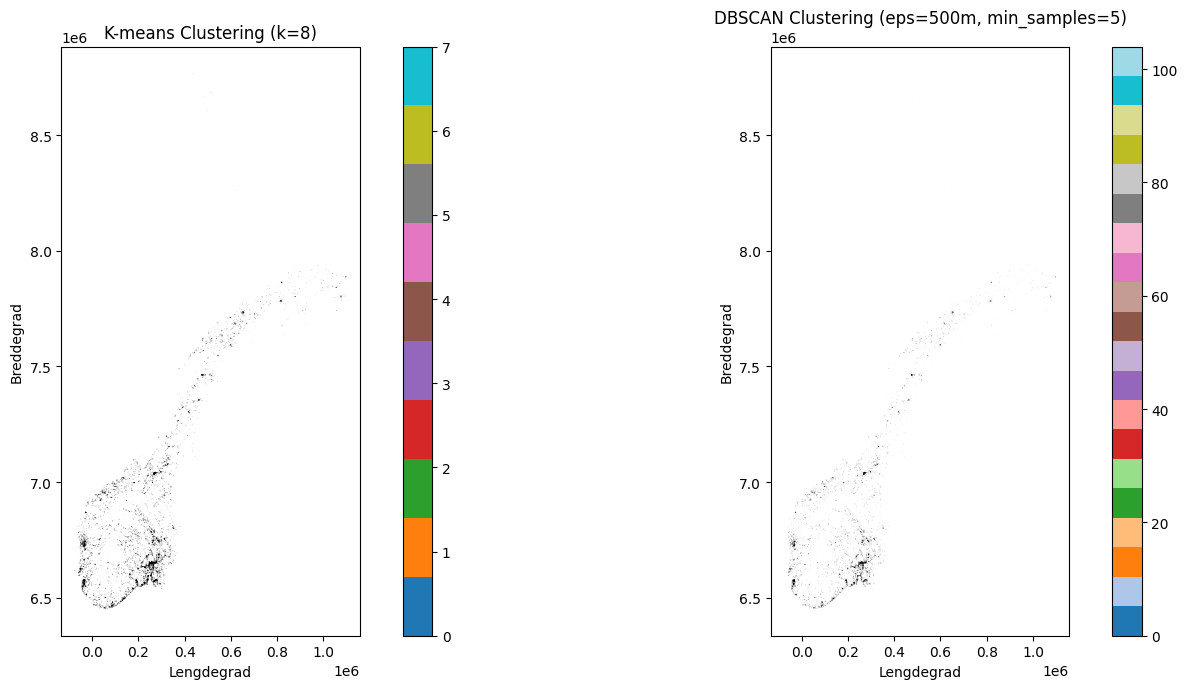

K-means: 8 clusters
DBSCAN: 105 clusters, 9316 støypunkter


In [45]:
from sklearn.cluster import DBSCAN, KMeans
import numpy as np

# Forbered koordinater fra bygningssentroidene
coords = np.array([[geom.x, geom.y] for geom in buildings.geometry.centroid])

# K-means clustering (8 clusters)
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
buildings['cluster_kmeans'] = kmeans.fit_predict(coords)

# DBSCAN clustering (tetthet-basert)
dbscan = DBSCAN(eps=500, min_samples=5)
buildings['cluster_dbscan'] = dbscan.fit_predict(coords)

# Visualiser begge side ved side
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# K-means
buildings.plot(ax=axes[0], column='cluster_kmeans', cmap='tab10', alpha=0.7, edgecolor='k', linewidth=0.5, legend=True)
axes[0].set_title('K-means Clustering (k=8)')
axes[0].set_xlabel('Lengdegrad')
axes[0].set_ylabel('Breddegrad')

# DBSCAN
noise = buildings[buildings['cluster_dbscan'] == -1]
clusters = buildings[buildings['cluster_dbscan'] != -1]
noise.plot(ax=axes[1], color='lightgray', alpha=0.3, edgecolor='k', linewidth=0.5)
clusters.plot(ax=axes[1], column='cluster_dbscan', cmap='tab20', alpha=0.7, edgecolor='k', linewidth=0.5, legend=True)
axes[1].set_title('DBSCAN Clustering (eps=500m, min_samples=5)')
axes[1].set_xlabel('Lengdegrad')
axes[1].set_ylabel('Breddegrad')

plt.tight_layout()
plt.show()

print(f"K-means: {len(set(buildings['cluster_kmeans']))} clusters")
print(f"DBSCAN: {len(set(buildings['cluster_dbscan'])) - 1} clusters, {list(buildings['cluster_dbscan']).count(-1)} støypunkter")

# Oppsummering og prøv selv

## Oppgaver å prøve selv

### Oppgave 1: Romlig analyse av bygninger
- Finn de 10 største bygningene i datasettet og visualiser dem på et kart
- Beregn tetthet av bygninger i ulike områder ved å bruke grid-celler
- Identifiser bygninger som ligger nærmere enn 20 meter til hverandre

### Oppgave 2: Flomrisikoanalyse
- Beregn hvor mange kvadratmeter bygningsareal som ligger i hver flomrisikosone (10-, 20-, 50-, 100-, 200-års intervaller)
- Lag en buffer på 25 meter rundt flomsoner og finn bygninger i denne buffersonen (potensiell utvidet risiko)
- Visualiser bygninger i flomsoner farget etter gjentaksintervall

### Oppgave 3: Sykkelruteanalyse
- Beregn total lengde av sykkelruter i datasettet
- Finn områder hvor flere sykkelruter krysser (bruk `overlay()` med `intersection`)
- Identifiser sykkelruter som går gjennom flomsoner og beregn hvor stor andel av hver rute som er utsatt for flom

### Oppgave 4: Avansert kombinasjonsanalyse
- Finn bygninger som både ligger i flomsoner OG innen 50 meter fra sykkelruter
- Lag et heatmap som viser hvor mange bygninger som finnes i hver grid-celle
- Beregn gjennomsnittlig avstand fra bygninger til nærmeste flomrisikosone
- Identifiser "trygge sykkelruter" som ikke går gjennom flomsoner

### Oppgave 5: Visualisering
- Lag et interaktivt kart med Folium som viser alle tre datasett samtidig med ulike farger/symboler
- Lag en choropleth-visualisering av bygningsareal per grid-celle
- Visualiser sykkelruter farget etter total lengde eller sesongtype

### Oppgave 6: Export og rapportering
- Eksporter analyse-resultater til nye GeoParquet-filer
- Lag en oppsummering med pandas av antall bygninger per bygningstype i flomsoner
- Generer statistikk for hvor mange meter sykkelrute som er i flomsoner